In [1]:
!nvidia-smi

Sun Nov 21 22:04:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   34C    P8    10W / 250W |   1529MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
PATH_TO_DATA = "data/lab1/"


NLP From Scratch: Translation with a Sequence to Sequence Network and Attention
*******************************************************************************
**Author**: `Sean Robertson <https://github.com/spro/practical-pytorch>`_

This is the third and final tutorial on doing "NLP From Scratch", where we
write our own classes and functions to preprocess the data to do our NLP
modeling tasks. We hope after you complete this tutorial that you'll proceed to
learn how `torchtext` can handle much of this preprocessing for you in the
three tutorials immediately following this one.

In this project we will be teaching a neural network to translate from
French to English.

::

    [KEY: > input, = target, < output]

    > il est en train de peindre un tableau .
    = he is painting a picture .
    < he is painting a picture .

    > pourquoi ne pas essayer ce vin delicieux ?
    = why not try that delicious wine ?
    < why not try that delicious wine ?

    > elle n est pas poete mais romanciere .
    = she is not a poet but a novelist .
    < she not not a poet but a novelist .

    > vous etes trop maigre .
    = you re too skinny .
    < you re all alone .

... to varying degrees of success.

This is made possible by the simple but powerful idea of the `sequence
to sequence network <https://arxiv.org/abs/1409.3215>`__, in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

To improve upon this model we'll use an `attention
mechanism <https://arxiv.org/abs/1409.0473>`__, which lets the decoder
learn to focus over a specific range of the input sequence.

**Recommended Reading:**

I assume you have at least installed PyTorch, know Python, and
understand Tensors:

-  https://pytorch.org/ For installation instructions
-  :doc:`/beginner/deep_learning_60min_blitz` to get started with PyTorch in general
-  :doc:`/beginner/pytorch_with_examples` for a wide and deep overview
-  :doc:`/beginner/former_torchies_tutorial` if you are former Lua Torch user


It would also be useful to know about Sequence to Sequence networks and
how they work:

-  `Learning Phrase Representations using RNN Encoder-Decoder for
   Statistical Machine Translation <https://arxiv.org/abs/1406.1078>`__
-  `Sequence to Sequence Learning with Neural
   Networks <https://arxiv.org/abs/1409.3215>`__
-  `Neural Machine Translation by Jointly Learning to Align and
   Translate <https://arxiv.org/abs/1409.0473>`__
-  `A Neural Conversational Model <https://arxiv.org/abs/1506.05869>`__

You will also find the previous tutorials on
:doc:`/intermediate/char_rnn_classification_tutorial`
and :doc:`/intermediate/char_rnn_generation_tutorial`
helpful as those concepts are very similar to the Encoder and Decoder
models, respectively.

**Requirements**



In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Loading data files
==================

The data for this project is a set of many thousands of English to
French translation pairs.

`This question on Open Data Stack
Exchange <https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages>`__
pointed me to the open translation site https://tatoeba.org/ which has
downloads available at https://tatoeba.org/eng/downloads - and better
yet, someone did the extra work of splitting language pairs into
individual text files here: https://www.manythings.org/anki/

The English to French pairs are too big to include in the repo, so
download to ``data/eng-fra.txt`` before continuing. The file is a tab
separated list of translation pairs:

::

    I am cold.    J'ai froid.

.. Note::
   Download the data from
   `here <https://download.pytorch.org/tutorial/data.zip>`_
   and extract it to the current directory.



Similar to the character encoding used in the character-level RNN
tutorials, we will be representing each word in a language as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

.. figure:: /_static/img/seq-seq-images/word-encoding.png
   :alt:





We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Lang`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [6]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.




In [7]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Zа-я-А-ЯёЁ\-.!?]+", r" ", s)
    return s

To read the data file we will split the file into lines, and then split
lines into pairs. The files are all English → Other Language, so if we
want to translate from Other Language → English I added the ``reverse``
flag to reverse the pairs.




In [8]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(f'{PATH_TO_DATA}/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences. Here the maximum length is 10 words (that includes
ending punctuation) and we're filtering to sentences that translate to
the form "I am" or "He is" etc. (accounting for apostrophes replaced
earlier).




In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [10]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print(len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=True)
print(random.choice(pairs))

Reading lines...
Read 190206 sentence pairs
137614
Trimmed to 137614 sentence pairs
Counting words...
Counted words:
fra 21448
eng 11935
['les deux facons d ecrire sont correctes .', 'both spellings are correct .']


In [11]:
pairs[:10]

[['va !', 'go .'],
 ['marche .', 'go .'],
 ['bouge !', 'go .'],
 ['salut !', 'hi .'],
 ['salut .', 'hi .'],
 ['cours !', 'run !'],
 ['courez !', 'run !'],
 ['prenez vos jambes a vos cous !', 'run !'],
 ['file !', 'run !'],
 ['filez !', 'run !']]

The Seq2Seq Model
=================

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A `Sequence to Sequence network <https://arxiv.org/abs/1409.3215>`__, or
seq2seq network, or `Encoder Decoder
network <https://arxiv.org/pdf/1406.1078v3.pdf>`__, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

.. figure:: /_static/img/seq-seq-images/seq2seq.png
   :alt:

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages.

Consider the sentence "Je ne suis pas le chat noir" → "I am not the
black cat". Most of the words in the input sentence have a direct
translation in the output sentence, but are in slightly different
orders, e.g. "chat noir" and "black cat". Because of the "ne/pas"
construction there is also one more word in the input sentence. It would
be difficult to produce a correct translation directly from the sequence
of input words.

With a seq2seq model the encoder creates a single vector which, in the
ideal case, encodes the "meaning" of the input sequence into a single
vector — a single point in some N dimensional space of sentences.




The Encoder
-----------

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

.. figure:: /_static/img/seq-seq-images/encoder-network.png
   :alt:





In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




Simple Decoder
^^^^^^^^^^^^^^

In the simplest seq2seq decoder we use only last output of the encoder.
This last output is sometimes called the *context vector* as it encodes
context from the entire sequence. This context vector is used as the
initial hidden state of the decoder.

At every step of decoding, the decoder is given an input token and
hidden state. The initial input token is the start-of-string ``<SOS>``
token, and the first hidden state is the context vector (the encoder's
last hidden state).

.. figure:: /_static/img/seq-seq-images/decoder-network.png
   :alt:





In [13]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, encoder_outputs=None):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden, None

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




Attention Decoder
^^^^^^^^^^^^^^^^^

If only the context vector is passed between the encoder and decoder,
that single vector carries the burden of encoding the entire sentence.

Attention allows the decoder network to "focus" on a different part of
the encoder's outputs for every step of the decoder's own outputs. First
we calculate a set of *attention weights*. These will be multiplied by
the encoder output vectors to create a weighted combination. The result
(called ``attn_applied`` in the code) should contain information about
that specific part of the input sequence, and thus help the decoder
choose the right output words.

.. figure:: https://i.imgur.com/1152PYf.png
   :alt:

Calculating the attention weights is done with another feed-forward
layer ``attn``, using the decoder's input and hidden state as inputs.
Because there are sentences of all sizes in the training data, to
actually create and train this layer we have to choose a maximum
sentence length (input length, for encoder outputs) that it can apply
to. Sentences of the maximum length will use all the attention weights,
while shorter sentences will only use the first few.

.. figure:: /_static/img/seq-seq-images/attention-decoder-network.png
   :alt:





In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

<div class="alert alert-info"><h4>Note</h4><p>There are other forms of attention that work around the length
  limitation by using a relative position approach. Read about "local
  attention" in `Effective Approaches to Attention-based Neural Machine
  Translation <https://arxiv.org/abs/1508.04025>`__.</p></div>

Training
========

Preparing Training Data
-----------------------

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair, input_lang, output_lang):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model
------------------

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the ``<SOS>`` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but `when the trained
network is exploited, it may exhibit
instability <http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf>`__.

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [16]:
teacher_forcing_ratio = 0.9


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [17]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [18]:
def trainIters(encoder, decoder, n_iters, pairs, input_lang, output_lang,
               print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs), input_lang, output_lang)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

Plotting results
----------------

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [19]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Evaluation
==========

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [20]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            if decoder_attention is not None:
                decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [21]:
def evaluateRandomly(encoder, decoder, pairs, input_lang, output_lang, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Training and Evaluating
=======================

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
reasonable results.

.. Note::
   If you run this notebook you can train, interrupt the kernel,
   evaluate, and continue training later. Comment out the lines where the
   encoder and decoder are initialized and run ``trainIters`` again.




0m 58s (- 18m 37s) (5000 5%) 4.2652
1m 53s (- 17m 4s) (10000 10%) 3.5142
2m 48s (- 15m 56s) (15000 15%) 3.1966
3m 43s (- 14m 54s) (20000 20%) 2.9846
4m 38s (- 13m 54s) (25000 25%) 2.8491
5m 32s (- 12m 56s) (30000 30%) 2.7295
6m 27s (- 11m 58s) (35000 35%) 2.6372
7m 21s (- 11m 1s) (40000 40%) 2.5689
8m 15s (- 10m 5s) (45000 45%) 2.4628
9m 9s (- 9m 9s) (50000 50%) 2.4547
10m 4s (- 8m 14s) (55000 55%) 2.3805
10m 58s (- 7m 19s) (60000 60%) 2.3249
11m 52s (- 6m 23s) (65000 65%) 2.3227
12m 47s (- 5m 28s) (70000 70%) 2.2719
13m 41s (- 4m 33s) (75000 75%) 2.2254
14m 36s (- 3m 39s) (80000 80%) 2.2060
15m 30s (- 2m 44s) (85000 85%) 2.1906
16m 24s (- 1m 49s) (90000 90%) 2.1503
17m 19s (- 0m 54s) (95000 95%) 2.1220
18m 14s (- 0m 0s) (100000 100%) 2.1203


<Figure size 432x288 with 0 Axes>

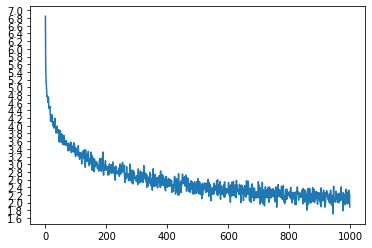

In [22]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, pairs, input_lang=input_lang, output_lang=output_lang, print_every=5000)

In [23]:
#trainIters(encoder1, attn_decoder1, 10000, print_every=500)
    

In [24]:
evaluateRandomly(encoder1, attn_decoder1, pairs, input_lang, output_lang)

> je suis reticent a aider tom .
= i m reluctant to help tom .
< i m used to help tom . <EOS>

> si vous voulez discuter discutons !
= if you want to talk let s talk .
< if you want to see if so much . <EOS>

> il joue dans sa chambre .
= he is playing in his room .
< he is in his room . <EOS>

> et si on faisait une pause ?
= what do you say to taking a rest ?
< and should i were ? <EOS>

> il nettoie son placard .
= he s cleaning out his closet .
< he s his teacher . <EOS>

> quel est donc tout ce bruit ?
= what s all this noise ?
< what s all the matter ? <EOS>

> ne vous y rendez pas tete nue .
= don t go without a hat .
< don t make your word . <EOS>

> il voyagea a travers le pays .
= he traveled throughout the country .
< he made his word . <EOS>

> j ai hate de te voir .
= i can t wait to see you .
< i can see you see . <EOS>

> cherchez-vous quelqu un ?
= are you looking for someone ?
< are you someone ? <EOS>



Visualizing Attention
---------------------

A useful property of the attention mechanism is its highly interpretable
outputs. Because it is used to weight specific encoder outputs of the
input sequence, we can imagine looking where the network is focused most
at each time step.

You could simply run ``plt.matshow(attentions)`` to see attention output
displayed as a matrix, with the columns being input steps and rows being
output steps:




['i', 'm', 'too', 'cold', '.', '<EOS>']


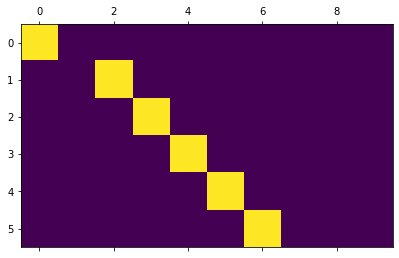

In [26]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "je suis trop froid .", input_lang, output_lang)
plt.matshow(attentions.numpy())
print(output_words)

For a better viewing experience we will do the extra work of adding axes
and labels:




In [27]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence, input_lang, output_lang):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

input = elle a cinq ans de moins que moi .
output = she has two years than me . <EOS>


/tmp/ipykernel_14839/4163146951.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_14839/4163146951.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


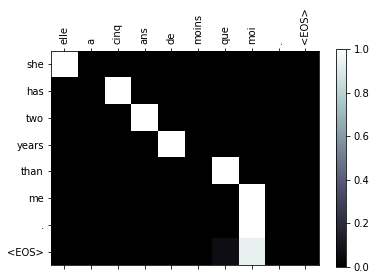

input = elle est trop petit .
output = she s too fast . <EOS>


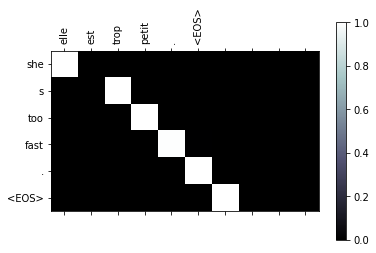

input = je ne crains pas de mourir .
output = i m not going to die . <EOS>


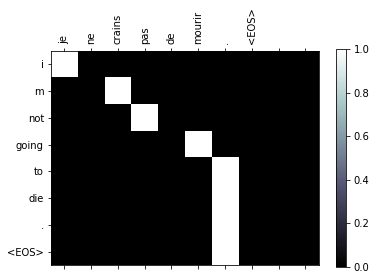

input = c est un jeune directeur plein de talent .
output = he s a young young friend . <EOS>


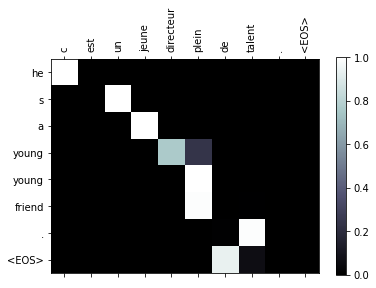

In [28]:



evaluateAndShowAttention("elle a cinq ans de moins que moi .", input_lang, output_lang)

evaluateAndShowAttention("elle est trop petit .", input_lang, output_lang)

evaluateAndShowAttention("je ne crains pas de mourir .", input_lang, output_lang)

evaluateAndShowAttention("c est un jeune directeur plein de talent .", input_lang, output_lang)

Exercises
=========

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pre-trained word embeddings such as word2vec or
   GloVe
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there




# ENG - FRA

In [29]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', reverse=False)
print(random.choice(pairs))

Reading lines...
Read 190206 sentence pairs
137614
Trimmed to 137614 sentence pairs
Counting words...
Counted words:
eng 11935
fra 21448
['you didn t answer my question .', 'tu ne repondis pas a ma question .']


0m 28s (- 23m 31s) (2000 2%) 5.2996
0m 53s (- 21m 26s) (4000 4%) 4.4666
1m 18s (- 20m 32s) (6000 6%) 4.1653
1m 43s (- 19m 52s) (8000 8%) 3.8776
2m 8s (- 19m 18s) (10000 10%) 3.7753
2m 33s (- 18m 46s) (12000 12%) 3.6852
2m 58s (- 18m 17s) (14000 14%) 3.5144
3m 23s (- 17m 49s) (16000 16%) 3.4570
3m 48s (- 17m 20s) (18000 18%) 3.3650
4m 13s (- 16m 55s) (20000 20%) 3.3420
4m 38s (- 16m 28s) (22000 22%) 3.2587
5m 3s (- 16m 2s) (24000 24%) 3.2117
5m 29s (- 15m 36s) (26000 26%) 3.1360
5m 54s (- 15m 10s) (28000 28%) 3.1348
6m 19s (- 14m 44s) (30000 30%) 3.0527
6m 43s (- 14m 18s) (32000 32%) 3.0723
7m 8s (- 13m 52s) (34000 34%) 2.9915
7m 33s (- 13m 26s) (36000 36%) 2.9358
7m 59s (- 13m 1s) (38000 38%) 2.9114
8m 24s (- 12m 36s) (40000 40%) 2.8806
8m 49s (- 12m 10s) (42000 42%) 2.8656
9m 14s (- 11m 45s) (44000 44%) 2.8278
9m 39s (- 11m 19s) (46000 46%) 2.7797
10m 4s (- 10m 54s) (48000 48%) 2.7901
10m 29s (- 10m 29s) (50000 50%) 2.7259
10m 54s (- 10m 4s) (52000 52%) 2.7479
11m 19s (- 9m 38s) (5400

<Figure size 432x288 with 0 Axes>

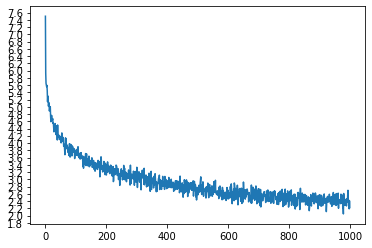

In [30]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, pairs, input_lang=input_lang, output_lang=output_lang, print_every=2000)


In [31]:
evaluateRandomly(encoder1, attn_decoder1, pairs, input_lang, output_lang)

> do i have to change my diet ?
= dois-je alterer mon regime ?
< avez-vous de faire mes cheveux ? <EOS>

> i m at my place .
= je suis chez moi .
< je suis a ma mere . <EOS>

> the population of this village had decreased .
= la population de ce village avait diminue .
< le voleur a fait son bureau . <EOS>

> the walls were painted light brown .
= les murs etaient peints de couleur ocre .
< les arbres etaient etaient etaient . <EOS>

> i wish i had a camera .
= j aimerais disposer d un appareil photo .
< j ai fait avoir fait une pomme . <EOS>

> the boys played in the mud .
= les garcons jouerent dans la boue .
< le chat dans le feu . <EOS>

> i didn t finish the job .
= je n ai pas fini le travail .
< je n ai pas pu le travail . <EOS>

> he s a lovely young man .
= c est un charmant jeune homme .
< il fait un homme homme . <EOS>

> i don t disagree .
= je n y suis pas oppose .
< je n ai pas de la . <EOS>

> are you sure they can do this ?
= etes-vous sur qu elles peuvent faire ca ?
< 

input = tom always works hard .
output = tom travaille toujours dur . <EOS>


/tmp/ipykernel_14839/4163146951.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_14839/4163146951.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)


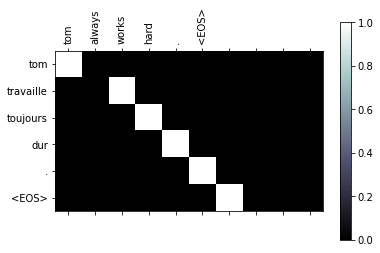

In [32]:
evaluateAndShowAttention("tom always works hard .", input_lang, output_lang)

# ENG-RU

In [33]:
input_lang, output_lang, pairs = prepareData('eng', 'rus', reverse=False)
print(random.choice(pairs))

Reading lines...
Read 431097 sentence pairs
356434
Trimmed to 356434 sentence pairs
Counting words...
Counted words:
eng 15022
rus 48024
['tell me about your wife .', 'расскажи мне о своеи жене .']


In [ ]:
hidden_size = 256
encoder1_er = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1_er = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


trainIters(encoder1_er, attn_decoder1_er, 140000, pairs, input_lang, output_lang,  print_every=5000)

1m 30s (- 40m 48s) (5000 3%) 5.1846
2m 55s (- 38m 2s) (10000 7%) 4.4794
4m 20s (- 36m 7s) (15000 10%) 4.1402
5m 44s (- 34m 27s) (20000 14%) 3.9400
7m 9s (- 32m 57s) (25000 17%) 3.7866
8m 35s (- 31m 29s) (30000 21%) 3.6121
10m 0s (- 30m 0s) (35000 25%) 3.5343
11m 24s (- 28m 31s) (40000 28%) 3.4360
12m 49s (- 27m 4s) (45000 32%) 3.3135
14m 14s (- 25m 38s) (50000 35%) 3.2384
15m 39s (- 24m 12s) (55000 39%) 3.2294
17m 4s (- 22m 45s) (60000 42%) 3.1440
18m 29s (- 21m 19s) (65000 46%) 3.1069
19m 54s (- 19m 54s) (70000 50%) 3.0560
21m 19s (- 18m 28s) (75000 53%) 3.0021
22m 44s (- 17m 3s) (80000 57%) 2.9833
24m 9s (- 15m 37s) (85000 60%) 2.9443
25m 33s (- 14m 12s) (90000 64%) 2.8778
26m 58s (- 12m 46s) (95000 67%) 2.8421
28m 24s (- 11m 21s) (100000 71%) 2.8069
29m 48s (- 9m 56s) (105000 75%) 2.7642
31m 13s (- 8m 31s) (110000 78%) 2.7396
32m 38s (- 7m 5s) (115000 82%) 2.7336
34m 3s (- 5m 40s) (120000 85%) 2.7175
35m 28s (- 4m 15s) (125000 89%) 2.7083
36m 53s (- 2m 50s) (130000 92%) 2.6780
38m 1

In [ ]:
evaluateRandomly(encoder1, attn_decoder1, pairs, input_lang, output_lang)

In [ ]:
evaluateAndShowAttention("tom always works hard .", input_lang, output_lang)

# Английский автоэнкодер


In [ ]:
#input_lang, ru_lang, eng_ru_pairs = prepareData('eng', 'rus', reverse=False)
ru_lang = output_lang
eng_ru_pairs = pairs
#output_lang = input_lang

eng_eng_pairs = [[f, f] for f, _ in eng_ru_pairs]
print(random.choice(eng_eng_pairs))

7m 55s (- 31m 43s) (28000 20%) 1.8890
8m 29s (- 31m 7s) (30000 21%) 1.8179
9m 3s (- 30m 33s) (32000 22%) 1.7658
9m 36s (- 29m 58s) (34000 24%) 1.7028
10m 10s (- 29m 23s) (36000 25%) 1.6915
10m 44s (- 28m 49s) (38000 27%) 1.6099
11m 17s (- 28m 14s) (40000 28%) 1.5614
11m 51s (- 27m 40s) (42000 30%) 1.5215
12m 25s (- 27m 6s) (44000 31%) 1.5275
12m 58s (- 26m 31s) (46000 32%) 1.4595
13m 32s (- 25m 57s) (48000 34%) 1.3947
14m 6s (- 25m 22s) (50000 35%) 1.4075
14m 39s (- 24m 48s) (52000 37%) 1.3562
15m 13s (- 24m 14s) (54000 38%) 1.3209
15m 46s (- 23m 40s) (56000 40%) 1.2477
16m 20s (- 23m 6s) (58000 41%) 1.2602
16m 54s (- 22m 32s) (60000 42%) 1.2595
17m 28s (- 21m 58s) (62000 44%) 1.2193
18m 2s (- 21m 24s) (64000 45%) 1.1831
18m 35s (- 20m 51s) (66000 47%) 1.1789
19m 9s (- 20m 17s) (68000 48%) 1.1410
19m 43s (- 19m 43s) (70000 50%) 1.1709
20m 17s (- 19m 9s) (72000 51%) 1.1223
20m 51s (- 18m 36s) (74000 52%) 1.1041
21m 25s (- 18m 2s) (76000 54%) 1.1004
21m 58s (- 17m 28s) (78000 55%) 1.0595

<Figure size 432x288 with 0 Axes>

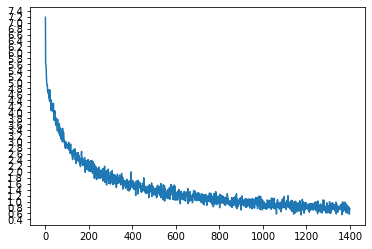

In [38]:
hidden_size = 256
encoder_eng = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder_eng = DecoderRNN(hidden_size, output_lang.n_words).to(device)

trainIters(encoder_eng, decoder_eng, 140000, eng_eng_pairs, input_lang, input_lang, print_every=2000)

Вот теперь модель хоть приблизительно норм

In [39]:
evaluateRandomly(encoder_eng, decoder_eng,  pairs, input_lang, input_lang)

> spring is coming .
= весна наступает .
< coming is coming . <EOS>

> the teacher was surrounded by her students .
= учительницу окружали ее ученики .
< the sun was by her by . <EOS>

> everyone is scared .
= все напуганы .
< everyone is scared . <EOS>

> that s what we re doing now .
= мы этим сеичас и занимаемся .
< that s what we re doing now . <EOS>

> we ll find one .
= мы одну наидем .
< we ll find one . <EOS>

> i didn t know you were so lonely .
= я не знал что ты так одинок .
< i didn t know you were so . <EOS>

> i haven t seen you in here before .
= я тебя раньше здесь не видел .
< i haven t seen you in here . <EOS>

> when did the movie start ?
= когда начался фильм ?
< when did the movie start ? <EOS>

> it happened at about half past four .
= это произошло приблизительно в половину пятого .
< it happened about at all six . <EOS>

> we re monks .
= мы монахи .
< we re wet . <EOS>



In [40]:
# Заморозим энкодер и обучим eng-rus
for param in encoder_eng.parameters():
    param.requires_grad = False

['how do you know tom won t win ?', 'откуда ты знаешь что том не победит ?']
0m 18s (- 23m 42s) (1000 1%) 5.7896
0m 32s (- 21m 12s) (2000 2%) 5.0430
0m 47s (- 20m 11s) (3000 3%) 4.7771
1m 1s (- 19m 36s) (4000 5%) 4.6166
1m 16s (- 19m 10s) (5000 6%) 4.5805
1m 31s (- 18m 44s) (6000 7%) 4.4086
1m 45s (- 18m 24s) (7000 8%) 4.3771
2m 0s (- 18m 5s) (8000 10%) 4.1873
2m 15s (- 17m 46s) (9000 11%) 4.2614
2m 29s (- 17m 27s) (10000 12%) 4.0618
2m 44s (- 17m 11s) (11000 13%) 4.1104
2m 59s (- 16m 55s) (12000 15%) 4.0395
3m 13s (- 16m 39s) (13000 16%) 3.9591
3m 28s (- 16m 23s) (14000 17%) 3.9245
3m 43s (- 16m 7s) (15000 18%) 3.8369
3m 57s (- 15m 51s) (16000 20%) 3.7776
4m 12s (- 15m 35s) (17000 21%) 3.7297
4m 27s (- 15m 21s) (18000 22%) 3.7765
4m 42s (- 15m 5s) (19000 23%) 3.7800
4m 56s (- 14m 50s) (20000 25%) 3.6600
5m 11s (- 14m 35s) (21000 26%) 3.6833
5m 26s (- 14m 19s) (22000 27%) 3.5962
5m 40s (- 14m 4s) (23000 28%) 3.5898
5m 55s (- 13m 49s) (24000 30%) 3.6039
6m 10s (- 13m 34s) (25000 31%) 3.

<Figure size 432x288 with 0 Axes>

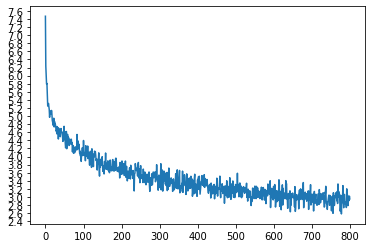

In [41]:
print(random.choice(eng_ru_pairs))

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder_eng, attn_decoder1, 80000, eng_ru_pairs, input_lang, ru_lang, print_every=1000)

In [42]:
evaluateRandomly(encoder_eng, attn_decoder1, eng_ru_pairs, input_lang, ru_lang)

> tom started the engine .
= том запустил двигатель .
< том начал . <EOS>

> when was this university founded ?
= когда был открыт этот университет ?
< когда это было была ? <EOS>

> tom wanted to see me .
= том хотел меня видеть .
< том хотел увидеть меня . <EOS>

> are you going to the movies ?
= ты идешь в кино ?
< вы идете на поезд ? <EOS>

> you know this .
= ты это знаешь .
< ты это знаешь . <EOS>

> who got hurt ?
= кого поранило ?
< кто мог ? <EOS>

> we need a map .
= нам нужна карта .
< нам нужен нужен . <EOS>

> wow that s so interesting !
= ух ты как интересно !
< какая это не так ли произошло <EOS>

> i must ve missed something .
= я наверное что-то пропустил .
< я должен больше был . <EOS>

> tom told me he didn t smoke .
= том сказал мне что он не курит .
< том сказал мне что он не может . <EOS>

